<a href="https://colab.research.google.com/github/margeumkim/BRIDGEMAIL/blob/master/BERT_FineTune_SelectWords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning Tutorial with PyTorch
Ref: Chris McCormick and Nick Ryan's notebook

## 1.1. Using Colab GPU for Training

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)

Then run the following cell to confirm that the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library

Next, let's install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use BertForSequenceClassification.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

In [3]:
!pip install transformers

     |████████████████████████████████| 675kB 9.5MB/s 
     |████████████████████████████████| 1.1MB 31.1MB/s 
     |████████████████████████████████| 3.8MB 48.2MB/s 
     |████████████████████████████████| 890kB 50.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=fcaf704fceba167069a89f6b69749cff7f4670f4adc5ee680326edb41100d0fc
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


The code in this notebook is actually a simplified version of the run_glue.py example script from huggingface.

run_glue.py is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models here). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.

Unfortunately, all of this configurability comes at the cost of readability. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on.

# 2. Loading CoLA Dataset

We'll use [The Corpus of Linguistic Acceptability (CoLA) ](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.

## 2.1. Download & Extract
Import the datasets

In [4]:
 from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import pandas as pd


# Import the training data
path = "/content/drive/My Drive/data/train_set_6733.csv"
train_df = pd.read_csv(path)

# Report the number of sentences.
print('Number of training messages: {:,}\n'.format(train_df.shape[0]))


# Dataset is now stored in a Pandas Dataframe

Number of training messages: 586



In [ ]:
# Import the dictionary data 
path_dict = "/content/drive/My Drive/data/dict_topic_for_bert.csv"
dict_for_bert = pd.read_csv(path_dict)

In [ ]:
train_df.iloc[10]["content"]
# . or >  split --> each sentence == join with the primary category
# . or >  split --> each sentence == join with the 3.1 
# . or >  split --> each sentence == join with the 3.6
# . or >  split --> each sentence == join with the 3.2

'Just a "heads up" ... Ken may get a call from Gov Gilmore regarding the Republican Governors\' Association. Below are Sue Landwehr\'s recommendations (with which I concur). Let me know if he calls and let us know if you need any additional information. ----- Forwarded by Steven J Kean/NA/Enron on 10/04/2000 09:20 AM ----- Richard Shapiro@ENRON 10/04/2000 07:17 AM To: Susan M Landwehr/HOU/EES@EES cc: Elizabeth Linnell/NA/Enron@Enron@EES, Steven J Kean/NA/Enron@Enron@EES Subject: Re: RGA request I agree w/ your recommendations. Susan M Landwehr@EES 10/03/2000 09:50 PM To: Richard Shapiro/NA/Enron@Enron cc: Elizabeth Linnell/NA/Enron@Enron, Steven J Kean/NA/Enron@Enron Subject: RGA request Rick--you may have seen a recent letter from Gov Jim Gilmore and the RGA requesting that we make an additional contribution in the next few weeks to the RGA for their efforts on the upcoming November elections. They list a fundraising goal of $1,660,000 (just a bit aggressive!) If we are not able to ma

In [ ]:
train_df['any_3_1'].describe()  #23%

count    586.000000
mean       0.238908
std        0.426781
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: any_3_1, dtype: float64

In [ ]:
train_randselect = []
train_t31 = []
train_t36 = []
train_t32 = []

for index, row in train_df.iterrows():
    if type(row['content']) ==  str:
      for j in range(len(row['content'].split('.'))):
        train_randselect.append([row['primary_cat'], row['content'].split('.')[j]])
        train_t31.append([row['any_3_1'], row['content'].split('.')[j]])
        train_t36.append([row['any_3_6'], row['content'].split('.')[j]])
        train_t32.append([row['any_3_2'], row['content'].split('.')[j]])
    else:
      print (index)
      pass


1
54
83


KeyboardInterrupt: ignored

In [ ]:
train_t36_df = pd.DataFrame(train_t36, columns = ['Label', 'Sentence'])   # 34% yes  /// 32866 sentences
train_t31_df = pd.DataFrame(train_t31, columns = ['Label', 'Sentence'])   # 19% yes
train_t32_df = pd.DataFrame(train_t32, columns = ['Label', 'Sentence'])   # 14% yes

In [ ]:
term_list = dict_for_bert['Term']
term_list

0              lower
1             member
2              taken
3        spokeswoman
4             summer
            ...     
1494           light
1495        research
1496            love
1497    circumstance
1498           phone
Name: Term, Length: 1499, dtype: object

In [ ]:
train_t36_bool_list = []

for index, row in train_t36_df.iterrows():
    if type(row['Sentence']) == str:
        my_bool = any(item in list(row['Sentence'].split(' ')) for item in list(dict_for_bert['Term'])) 
        #print (my_bool)
        train_t36_bool_list.append(my_bool)

train_t36_df['term_bool'] = train_t36_bool_list

KeyboardInterrupt: ignored

In [ ]:
train_t36_df['term_bool'].describe()

count     32866
unique        2
top        True
freq      25048
Name: term_bool, dtype: object

In [ ]:
train_t36_df_red = train_t36_df[train_t36_df['term_bool'] == True]
len(train_t36_df_red)

25048

In [ ]:
train_t36_df_red.to_csv('train_t36_ready_complete.csv', index=True)
!cp train_t36_ready_complete.csv "drive/My Drive/"

In [ ]:
train_t36_df_1000 = train_t36_df_red.sample(1000)

In [ ]:
train_t36_df_1000['Label'].describe()  # 33%

count    1000.000000
mean        0.333000
std         0.471522
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Label, dtype: float64

In [ ]:
train_t31_bool_list = []

for index, row in train_t31_df.iterrows():
    if type(row['Sentence']) == str:
        my_bool = any(item in list(row['Sentence'].split(' ')) for item in list(dict_for_bert['Term'])) 
        #print (my_bool)
        train_t31_bool_list.append(my_bool)

train_t31_df['term_bool'] = train_t31_bool_list

In [ ]:
train_t31_df['term_bool'].describe()

count     32866
unique        2
top        True
freq      25048
Name: term_bool, dtype: object

In [ ]:
train_t31_df_red = train_t31_df[train_t31_df['term_bool'] == True]
len(train_t31_df_red)

25048

In [ ]:
train_t31_df_red.to_csv('train_t31_ready_complete.csv', index=True)
!cp train_t31_ready_complete.csv "drive/My Drive/"

NameError: ignored

In [6]:
# Import the training data
import pandas as pd

path_dict = "/content/drive/My Drive/train_t31_ready_complete.csv"
train_t31_df_red = pd.read_csv(path_dict)

In [7]:
train_t31_df_3000 = train_t31_df_red.sample(3000)

In [8]:
train_t31_df_3000['Label'].describe()  # 18%

count    3000.000000
mean        0.191667
std         0.393678
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Label, dtype: float64

### Pick the subset that you want to train your model with!
Let's extract the sentences and labels of our training set as numpy ndarrays.

In [9]:
# Get the lists of sentences and their labels.
sentences = train_t31_df_3000.Sentence.values
labels = train_t31_df_3000.Label.values

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

3.1. BERT Tokenizer
To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.

In [11]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:   Copyright 2001 Los Angeles Times=20 Wednesday, June 20, 2001=20 The FERC's Action Is Good, Bad,Ugly=20 By PETER NAVARRO ?????The Federal Energy Regulatory Commission's new wholesale price caps wi= ll=20 save the Western states literally tens of billions of dollars in electricit= y=20 bills
Tokenized:  ['copyright', '2001', 'los', 'angeles', 'times', '=', '20', 'wednesday', ',', 'june', '20', ',', '2001', '=', '20', 'the', 'fe', '##rc', "'", 's', 'action', 'is', 'good', ',', 'bad', ',', 'ugly', '=', '20', 'by', 'peter', 'navarro', '?', '?', '?', '?', '?', 'the', 'federal', 'energy', 'regulatory', 'commission', "'", 's', 'new', 'wholesale', 'price', 'caps', 'wi', '=', 'll', '=', '20', 'save', 'the', 'western', 'states', 'literally', 'tens', 'of', 'billions', 'of', 'dollars', 'in', 'electric', '##it', '=', 'y', '=', '20', 'bills']
Token IDs:  [9385, 2541, 3050, 3349, 2335, 1027, 2322, 9317, 1010, 2238, 2322, 1010, 2541, 1027, 2322, 1996, 10768, 11890, 1005, 1055, 2895, 2003, 

When we actually convert all of our sentences, we'll use the tokenize.encode function to handle both steps, rather than calling tokenize and convert_tokens_to_ids separately.

Before we can do that, though, we need to talk about some of BERT's formatting requirements.



## 3.2. Tokenize Dataset

he transformers library provides a helpful encode function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [12]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1372 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1374


Just in case there are some longer test sentences, I'll set the maximum length to 64.

Now we're ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

Split the sentence into tokens.
Add the special [CLS] and [SEP] tokens.
Map the tokens to their IDs.
Pad or truncate all sentences to the same length.
Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks). Documentation is here.

In [13]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:   Copyright 2001 Los Angeles Times=20 Wednesday, June 20, 2001=20 The FERC's Action Is Good, Bad,Ugly=20 By PETER NAVARRO ?????The Federal Energy Regulatory Commission's new wholesale price caps wi= ll=20 save the Western states literally tens of billions of dollars in electricit= y=20 bills
Token IDs: tensor([  101,  9385,  2541,  3050,  3349,  2335,  1027,  2322,  9317,  1010,
         2238,  2322,  1010,  2541,  1027,  2322,  1996, 10768, 11890,  1005,
         1055,  2895,  2003,  2204,  1010,  2919,  1010,  9200,  1027,  2322,
         2011,  2848, 23524,  1029,  1029,  1029,  1029,  1029,  1996,  2976,
         2943, 10738,  3222,  1005,  1055,  2047, 17264,  3976,  9700, 15536,
         1027,  2222,  1027,  2322,  3828,  1996,  2530,  2163,  6719, 15295,
         1997, 25501,  1997,  6363,  1999,  3751,  4183,  1027,  1061,  1027,
         2322,  8236,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0

## 3.4. Training & Validation Split 
Divide up our training set to use 90% for training and 10% for validation.

In [14]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,700 training samples
  300 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model.

## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

Here is the current list of classes provided for fine-tuning:

BertModel
BertForPreTraining
BertForMaskedLM
BertForNextSentencePrediction
BertForSequenceClassification - The one we'll use.
BertForTokenClassification
BertForQuestionAnswering
The documentation for these can be found under here.

We'll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for from_pretrained can be found here, with the additional parameters defined here.

In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 4.2. Optimizer & Learning Rate Scheduler
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4


We chose:

* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in run_glue.py [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).


In [18]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [19]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4  # I am doing 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop
Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase.

> Thank you to Stas Bekman for contributing the insights and code for using validation loss to detect over-fitting!

Training:

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass.
** In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress

Evalution:

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line.

> PyTorch also has some beginner tutorials which you may also find helpful.

Define a helper function for calculating accuracy.

In [20]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [21]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

We're ready to kick off the training!

In [22]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     85.    Elapsed: 0:01:10.
  Batch    80  of     85.    Elapsed: 0:02:18.

  Average training loss: 0.51
  Training epcoh took: 0:02:26

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.44
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     85.    Elapsed: 0:01:08.
  Batch    80  of     85.    Elapsed: 0:02:17.

  Average training loss: 0.49
  Training epcoh took: 0:02:24

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.44
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     85.    Elapsed: 0:01:08.
  Batch    80  of     85.    Elapsed: 0:02:17.

  Average training loss: 0.48
  Training epcoh took: 0:02:24

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.44
  Validation took: 0:00:06

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     85.    Elapsed: 0:01:08.
  Batch    80  of     85.    Elapsed: 0:

Let's view the summary of the training process.

In [23]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.51,0.44,0.84,0:02:26,0:00:06
2,0.49,0.44,0.84,0:02:24,0:00:06
3,0.48,0.44,0.84,0:02:24,0:00:06
4,0.46,0.44,0.84,0:02:24,0:00:06


Notice that, while the the training loss is going down with each epoch, the validation loss is not changing much.

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on.

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


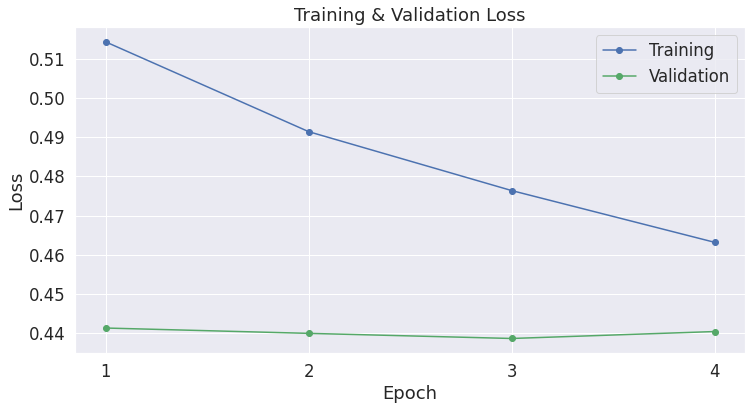

In [24]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set
Now we'll load the holdout dataset and prepare inputs just as we did with the training set. 

## 5.1. Data Preparation
We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [56]:
import pandas as pd


# Import the test data
path_test = "/content/drive/My Drive/data/test_set_6733.csv"
test_df = pd.read_csv(path_test)


# Report the number of sentences.
print('Number of test messages: {:,}\n'.format(test_df.shape[0]))


# Import the dictionary data 
#path_dict = "/content/drive/My Drive/data/dict_topic_for_bert.csv"
#dict_for_bert = pd.read_csv(path_dict)


# Describe the label info
test_df['any_3_1'].describe()  #23%


# Split messages into sentences and tag the labels
test_t31 = []

for index, row in test_df.iterrows():
    if type(row['content']) ==  str:
      for j in range(len(row['content'].split('.'))):
        test_t31.append([row['any_3_1'], row['content'].split('.')[j]])
    else:
      print (index)
      pass

test_df = pd.DataFrame(test_t31, columns = ['Label', 'Sentence'])   


# Go through the sentences, and check whether that sentence has any of the key words; keep only those sentences with keywords
term_list = dict_for_bert['Term']

test_t31_bool_list = []

for index, row in test_df.iterrows():
    if type(row['Sentence']) == str:
        my_bool = any(item in list(row['Sentence'].split(' ')) for item in list(dict_for_bert['Term'])) 
        #print (my_bool)
        test_t31_bool_list.append(my_bool)

test_df['term_bool'] = test_t31_bool_list
test_df['term_bool'].describe()

test_df_red = test_df[test_df['term_bool'] == True]
print(len(test_df_red))


# Save the file for later use
test_df_red.to_csv('test_t31_ready_complete.csv', index=True)
!cp test_t31_ready_complete.csv "drive/My Drive/"



Number of test messages: 289

115
16398


In [65]:
test_t31_df_3000.head()

,Label,Sentence,term_bool
7037,0,"The longer the delay in selling the bonds, t=...",True
19677,0,"??""It was usually Edison that was more combat...",True
3041,0,A couple walking a dog made the grisly discov...,True
12474,0,"Since the broilers remained hot, th= e=20 coo...",True
7864,1,"=20 ""It's too great of a risk,"" she said",True


In [75]:
# Randomly sample 3000 sentences 
test_t31_df_3000 = test_df_red.sample(3000)
print(test_t31_df_3000['Label'].describe())  # 18%


# Get the lists of sentences and their labels.
sentences = test_t31_df_3000.Sentence.values
labels = test_t31_df_3000.Label.values
  

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

count    3000.00
mean        0.17
std         0.38
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Label, dtype: float64


## 5.2. Evaluate on Test Set

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [76]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,000 test sentences...
    DONE.


In [77]:
print('Positive samples: %d of %d (%.2f%%)' % (test_t31_df_3000.Label.sum(), len(test_t31_df_3000.Label), (test_t31_df_3000.Label.sum() / len(test_t31_df_3000.Label) * 100.0)))

Positive samples: 518 of 3000 (17.27%)


Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:

In [78]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.

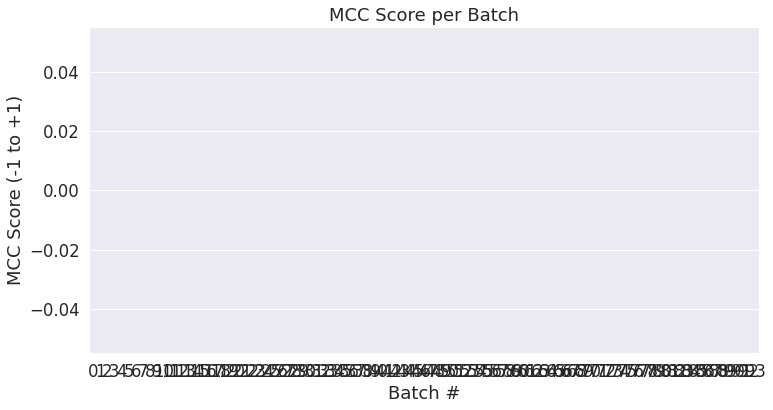

In [79]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [31]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [74]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))


Classification accuracy using BERT Fine Tuning: 0.00%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## A1. Saving & Loading Fine-Tuned Model
This first cell (taken from ```run_glue.py``` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [86]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/My Drive/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))



Saving model to /content/drive/My Drive/model_save/


('/content/drive/My Drive/model_save/vocab.txt',
 '/content/drive/My Drive/model_save/special_tokens_map.json',
 '/content/drive/My Drive/model_save/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [87]:
!ls -l --block-size=K '/content/drive/My Drive/model_save/'

total 427947K
-rw------- 1 root root      1K Jun 22 02:44 config.json
-rw------- 1 root root 427719K Jun 22 02:44 pytorch_model.bin
-rw------- 1 root root      1K Jun 22 02:44 special_tokens_map.json
-rw------- 1 root root      1K Jun 22 02:44 tokenizer_config.json
-rw------- 1 root root    227K Jun 22 02:44 vocab.txt


The largest file is the model weights, at around 428 megabytes.

# 6. Load the fine-tuned model to drive

In [93]:
# Load a trained model and vocabulary that you have fine-tuned
print (output_dir)
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

/content/drive/My Drive/model_save/


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Import a user's message

In [97]:
import pandas as pd


# Import the training data
path_to_emails_dt = "/content/drive/My Drive/data/emails.csv"
all_emails_df = pd.read_csv(path_to_emails_dt)

In [101]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [103]:
import email 

# Parse the emails into a list email objects
messages = list(map(email.message_from_string, all_emails_df['message']))
all_emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    all_emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
all_emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
all_emails_df['From'] = all_emails_df['From'].map(split_email_addresses)
all_emails_df['To'] = all_emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
all_emails_df['user'] = all_emails_df['file'].map(lambda x:x.split('/')[0])
del messages

#all_emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


#### Select kate-s

In [106]:
user_email_df = all_emails_df[all_emails_df['user']== 'symes-k']

In [108]:
print('Number of messages in this account: {:,}\n'.format(len(user_email_df)))

Number of messages in this account: 10,827



In [112]:
# message --> sentesces; check keywords in sentences 

sentences_list = []

for index, row in user_email_df.iterrows():
    if type(row['content']) ==  str:
      sentence_list = row['content'].split('.')
      for j in range(len(sentence_list)):
        if type(sentence_list[j]) == str:
          if any(item in list(sentence_list[j].split(' ')) for item in list(dict_for_bert['Term'])):
            sentences_list.append(sentence_list[j])
    else:
      print (index)
      pass


In [115]:
print('Number of eligible sentences in this account: {:,}\n'.format(len(sentences_list)))

Number of eligible sentences in this account: 87,042



In [124]:
import pandas as pd
# Import the dictionary data 
#path_dict = "/content/drive/My Drive/data/dict_topic_for_bert.csv"
#dict_for_bert = pd.read_csv(path_dict)

# Randomly sample 10000 sentences 
from random import sample 
sentences = sample(sentences_list, 10000)


In [128]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [132]:
# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Set the batch size.  
batch_size = 32  

# Put model in evaluation mode
model.eval()



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [135]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 

for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, grab hidden states
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
      hidden_states = outputs[0]

print('    DONE.')


    DONE.


In [136]:
hidden_states

tensor([[ 0.6897, -0.5112],
        [ 0.4758, -0.4587],
        [ 0.8842, -0.7432],
        [ 0.4402, -0.4614],
        [ 0.6914, -0.5895],
        [ 0.4027, -0.6871],
        [ 0.7188, -0.4990],
        [ 0.6533, -0.7773],
        [ 0.8631, -0.7833],
        [ 0.6461, -0.5056],
        [ 0.4788, -0.6270],
        [ 0.7530, -0.8769],
        [ 0.7376, -0.4931],
        [ 0.8011, -0.7978],
        [ 0.7727, -0.6083],
        [ 0.8982, -0.6668]], device='cuda:0')